# Import libraries

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch as th
import torch.nn.functional as F
import torch.nn as nn 
from torch import optim
from torch.utils.data import Dataset, DataLoader
import syft as sy
hook = sy.TorchHook(th)
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_poisson_deviance
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy import stats
import optuna
from optuna.trial import TrialState
from optuna.samplers import RandomSampler, TPESampler

# Set up

Set seed value

In [2]:
SEED = 212

Set random elements to seeds where possible

In [3]:
def seed_torch(seed=SEED):
    th.manual_seed(seed)
    random.seed(seed)
    th.cuda.manual_seed(seed)
    th.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    th.manual_seed(seed)
    th.backends.cudnn.benchmark = True
    th.backends.cudnn.deterministic = True

seed_torch()

Upload data set 

In [4]:
df = pd.read_csv('data/freMTPL2freq.csv')

## Transformations and corrections

In [5]:
#transformations and corrections
df['VehPower'] = df['VehPower'].astype(object) # categorical ordinal
df['ClaimNb'].values[df['ClaimNb']>4] = 4 # corrected for unreasonable observations (see M.V. Wuthrich)
df['VehAge'].values[df['VehAge']>20] = 20 # capped for NN training (see M.V. Wuthrich)
df['DrivAge'].values[df['DrivAge']>90] = 90 # capped for NN training (see M.V. Wuthrich)
df['BonusMalus'].values[df['BonusMalus']>150] = 150 # capped for NN training (see M.V. Wuthrich)
df['Density']=np.log(df['Density']) # logged for NN training     (see M.V. Wuthrich)
df['Exposure'].values[df['Exposure']>1] = 1 # corrected for unreasonable observations (see M.V. Wuthrich)
df_new = df.drop(['IDpol'], axis=1) # variable not used

Check for missing values

In [6]:
missing = df_new.isnull().sum()/df_new.shape[0]*100
missing

ClaimNb       0.0
Exposure      0.0
Area          0.0
VehPower      0.0
VehAge        0.0
DrivAge       0.0
BonusMalus    0.0
VehBrand      0.0
VehGas        0.0
Density       0.0
Region        0.0
dtype: float64

Encode the data as per Wuthrich

In [7]:
df_new_encoded = pd.get_dummies(df_new, columns=['VehBrand', 'Region'], drop_first=True)

Label encode oredered catergorical variables as per Wutrich

In [8]:
cleanup_nums = {"Area":     {"A": 1, "B": 2, "C": 3, "D": 4, "E":5, "F": 6},
                "VehGas":   {"Regular": 1, "Diesel": 2}
                }

Apply label encoding - NOT ONE-HOT/DUMMY

In [9]:
df_new_encoded = df_new_encoded.replace(cleanup_nums)

Apply MinMaxScaler as per Wuthrich

In [10]:
#TODO this should really be done for each train, val, test data
scaler = MinMaxScaler()
df_new_encoded[['Area', 'VehPower', 'VehAge','DrivAge','BonusMalus','Density']] = scaler.fit_transform(df_new_encoded[['Area', 'VehPower', 'VehAge','DrivAge','BonusMalus','Density']])

Summarize attribute distributions for data type of variables

In [11]:
no_obj_cols = [var for var in df_new_encoded.columns if df_new_encoded[var].dtype!='object']
df_new_encoded[no_obj_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
ClaimNb,678013.0,0.053179,0.237954,0.000000,0.000000,0.000000,0.000000,4.0
Exposure,678013.0,0.528545,0.364081,0.002732,0.180000,0.490000,0.990000,1.0
Area,678013.0,0.457940,0.276537,0.000000,0.200000,0.400000,0.600000,1.0
VehPower,678013.0,0.223148,0.186446,0.000000,0.090909,0.181818,0.272727,1.0
VehAge,678013.0,0.348806,0.269948,0.000000,0.100000,0.300000,0.550000,1.0
DrivAge,678013.0,0.381901,0.196248,0.000000,0.222222,0.361111,0.513889,1.0
BonusMalus,678013.0,0.097572,0.156079,0.000000,0.000000,0.000000,0.140000,1.0
VehGas,678013.0,1.489867,0.499898,1.000000,1.000000,1.000000,2.000000,2.0
Density,678013.0,0.586242,0.183313,0.000000,0.443157,0.585461,0.726545,1.0
VehBrand_B10,678013.0,0.026116,0.159480,0.000000,0.000000,0.000000,0.000000,1.0


Convert to numpy array

In [12]:
df_array=df_new_encoded.to_numpy()

Create Input and Output Data

In [13]:
X = df_array[:, 1:]
y = df_array[:, 0]

## Data Splitting

Split data into train and final test

In [14]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2,  random_state=SEED)

Split train into train and validation

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1,  random_state=SEED)

Join training and validation data back together

In [16]:
train_array = np.insert(X_train, 39, y_train, axis=1)
val_array = np.insert(X_val, 39, y_val, axis=1)

Split into chunks

In [17]:
NUM_AGENTS = 10
train_array_split = np.array_split(train_array, NUM_AGENTS)
val_array_split = np.array_split(val_array, NUM_AGENTS)

For each chunk create training and val arrays

In [18]:
for i in range(NUM_AGENTS):
    locals()['train_array_splitted_{}'.format(i)] = train_array_split[i]
    locals()['X_train_{}'.format(i)] = locals()['train_array_splitted_{}'.format(i)] [:, 0:39]
    locals()['y_train_{}'.format(i)] = locals()['train_array_splitted_{}'.format(i)] [:, 39]
    locals()['val_array_splitted_{}'.format(i)] = val_array_split[i]
    locals()['X_val_{}'.format(i)] = locals()['val_array_splitted_{}'.format(i)] [:, 0:39]
    locals()['y_val_{}'.format(i)] = locals()['val_array_splitted_{}'.format(i)] [:, 39]

Initialise dataset and create batch data loaders

In [19]:
class RegressionDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

train_dataset = RegressionDataset(th.from_numpy(X_train).float(), th.from_numpy(y_train).float())
val_dataset = RegressionDataset(th.from_numpy(X_val).float(), th.from_numpy(y_val).float())
test_dataset = RegressionDataset(th.from_numpy(X_test).float(), th.from_numpy(y_test).float())

Pick agent of choice

In [20]:
SELECTED_AGENT = 3

Partial datasets

In [21]:
locals()['train_dataset_{}'.format(SELECTED_AGENT)] = RegressionDataset(th.from_numpy(locals()['X_train_{}'.format(SELECTED_AGENT)]).float(), th.from_numpy(locals()['y_train_{}'.format(SELECTED_AGENT)]).float())
locals()['val_dataset_{}'.format(SELECTED_AGENT)] = RegressionDataset(th.from_numpy(locals()['X_val_{}'.format(SELECTED_AGENT)]).float(), th.from_numpy(locals()['y_val_{}'.format(SELECTED_AGENT)]).float())

# Model paramters

In [22]:
EPOCHS = 25
# Wutrich suggestion this may be better at 6,000 or so, 488169
BATCH_SIZE = 500000
NUM_FEATURES = 39
# Needed for Optuna?
LOG_INTERVAL = 10
# Set loss function change to true and then exp the output
criterion = nn.PoissonNLLLoss(log_input= True, full= True)

Check for CUDA

In [23]:
# force to use CPU as this appears actually faster
#device = th.device("cuda:0" if th.cuda.is_available() else "cpu")
device = th.device("cpu" if th.cuda.is_available() else "cpu")
print(device)

cpu


# Initialize Dataloaders

In [24]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

Initialize Dataloader for agents

In [25]:
locals()['train_loader_{}'.format(SELECTED_AGENT)] = DataLoader(dataset=locals()['train_dataset_{}'.format(SELECTED_AGENT)], batch_size=BATCH_SIZE, shuffle=True)
locals()['val_loader_{}'.format(SELECTED_AGENT)] = DataLoader(dataset=locals()['val_dataset_{}'.format(SELECTED_AGENT)], batch_size=1)

# Hyperparameter search on main model

We'll use a package called *Optuna* to do some basic hyperparameter searching to find a good set-up for our global model

Test

# Train Global model

Optuna doesn't save the weights of the model, see here: https://optuna.readthedocs.io/en/stable/faq.html#how-to-save-machine-learning-models-trained-in-objective-functions, so we'll build the best model in anger below

Set learning rate

In [26]:
#LEARNING_RATE = global_params["lr"]
LEARNING_RATE =  0.07610185548156075

## Define architecture

In [27]:
class MultipleRegression(nn.Module):
    def __init__(self, num_features):
        super(MultipleRegression, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 30)
        self.layer_2 = nn.Linear(30, 113)
        self.layer_out = nn.Linear(113, 1)
        # Define proportion or neurons to dropout
        self.dropout_1 = nn.Dropout(0.2077403165806469)
        self.dropout_2 = nn.Dropout(0.3623710627858965)
        self.relu = nn.ReLU()
    
    def forward(self, inputs):
        x = self.dropout_1(self.relu(self.layer_1(inputs)))
        x = self.dropout_2(self.relu(self.layer_2(inputs)))
        x = self.layer_out(x)

        return (x)

    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.relu(self.layer_2(test_inputs))
        x = self.layer_out(x)

        return (x)

In [37]:
#Define architecture
class MultipleRegression(nn.Module):
    def __init__(self, num_features):
        super(MultipleRegression, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 30)
        self.layer_2 = nn.Linear(30, 113)
        self.layer_out = nn.Linear(113, 1)
        # Define proportion or neurons to dropout
        self.dropout_1 = nn.Dropout(0.2077403165806469)
        self.dropout_2 = nn.Dropout(0.3623710627858965)
        
        self.relu = nn.ReLU()
    
    def forward(self, inputs):
        x = self.dropout_1(self.relu(self.layer_1(inputs)))
        x = self.dropout_2(self.relu(self.layer_2(x)))
        x = self.layer_out(x)

        return (x)

    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.relu(self.layer_2(x))
        x = self.layer_out(x)

        return (x)

Initialize the model. Transfer the model to GPU if available.

In [38]:
model = MultipleRegression(NUM_FEATURES)
model.to(device)
print(model)

MultipleRegression(
  (layer_1): Linear(in_features=39, out_features=30, bias=True)
  (layer_2): Linear(in_features=30, out_features=113, bias=True)
  (layer_out): Linear(in_features=113, out_features=1, bias=True)
  (dropout_1): Dropout(p=0.2077403165806469, inplace=False)
  (dropout_2): Dropout(p=0.3623710627858965, inplace=False)
  (relu): ReLU()
)


Set optimiser from Optuna

In [39]:
global_optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Training loop

In [40]:
def training_loop(model, train_loader, val_loader, optimizer, epochs=EPOCHS):
    
    # Before we start our training, let’s define a dictionary which will store the loss/epoch for both train and validation sets.
    loss_stats = {
    'train': [],
    "val": []
    }
   
    print("Begin training.")
    for e in tqdm(range(1, epochs+1)):
        
        # TRAINING
        train_epoch_loss = 0
        model.train()
        for X_train_batch, y_train_batch in train_loader:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            optimizer.zero_grad()
            
            y_train_pred = model(X_train_batch)
            
            train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
            
            train_loss.backward()
            optimizer.step()
            
            train_epoch_loss += train_loss.item()
            
            
        # VALIDATION    
        with th.no_grad():
            
            val_epoch_loss = 0
            
            model.eval()
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                
                y_val_pred = model(X_val_batch)
                            
                val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
                
                val_epoch_loss += val_loss.item()

        loss_stats['train'].append(train_epoch_loss/len(train_loader))
        loss_stats['val'].append(val_epoch_loss/len(val_loader))                              
        
        print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')

    return model, loss_stats

In [41]:
model, loss_stats = training_loop(model, train_loader, val_loader, global_optimizer)

Begin training.


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.00480 | Val Loss: 0.22715
Epoch 002: | Train Loss: 0.23449 | Val Loss: 0.23566
Epoch 003: | Train Loss: 0.24407 | Val Loss: 0.21742
Epoch 004: | Train Loss: 0.22869 | Val Loss: 0.21194
Epoch 005: | Train Loss: 0.22399 | Val Loss: 0.21351
Epoch 006: | Train Loss: 0.22410 | Val Loss: 0.21122
Epoch 007: | Train Loss: 0.22096 | Val Loss: 0.21131
Epoch 008: | Train Loss: 0.22028 | Val Loss: 0.21214
Epoch 009: | Train Loss: 0.22019 | Val Loss: 0.21068
Epoch 010: | Train Loss: 0.21824 | Val Loss: 0.20959
Epoch 011: | Train Loss: 0.21678 | Val Loss: 0.20999
Epoch 012: | Train Loss: 0.21647 | Val Loss: 0.21011
Epoch 013: | Train Loss: 0.21624 | Val Loss: 0.21006
Epoch 014: | Train Loss: 0.21600 | Val Loss: 0.21078
Epoch 015: | Train Loss: 0.21619 | Val Loss: 0.21154
Epoch 016: | Train Loss: 0.21705 | Val Loss: 0.21150
Epoch 017: | Train Loss: 0.21703 | Val Loss: 0.21092
Epoch 018: | Train Loss: 0.21657 | Val Loss: 0.21054
Epoch 019: | Train Loss: 0.21614 | Val Loss: 0

## Visualize Training Loss

We'll make a graphing function that we'll reuse throughout the notebook

In [42]:
def training_graph(loss_stats):
    train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
    plt.figure(figsize=(15,8))
    sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')

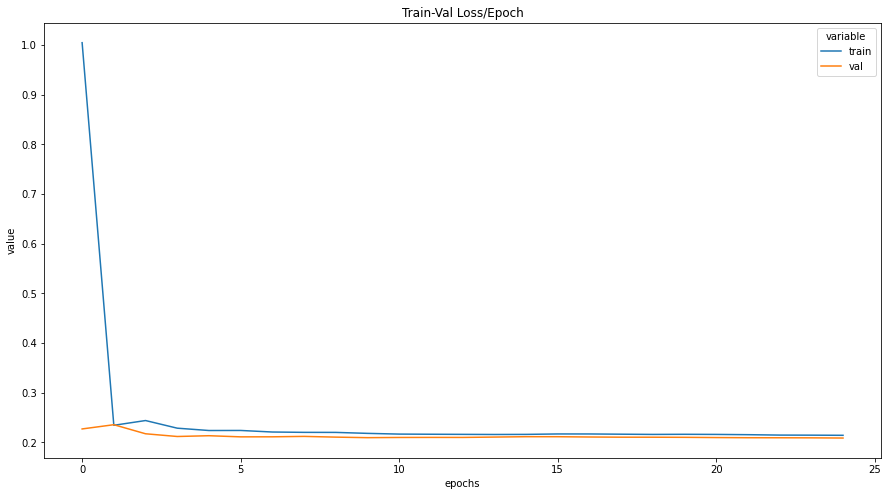

In [43]:
training_graph(loss_stats)

# Test model

We first make a list for our predictions. Then after switching the model to stop calculating gradients using `with th.no_grad()` we pass our X and Y **test** batches of data through the model. We then convert this to a list for further manipulation

In [44]:
y_pred_list = []
with th.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

Recall inputs were logged so need to apply exponential so that output will be strictly positive. See:https://pytorch.org/docs/stable/generated/torch.nn.PoissonNLLLoss.html

In [45]:
y_pred_list_exp=np.exp(y_pred_list)

We'll need to reuse this so again make this into a function

In [46]:
def exp_model_predictions(model):
    y_pred_list = []
    with th.no_grad():
        model.eval()
        for X_batch, _ in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_pred_list.append(y_test_pred.cpu().numpy())
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    
    return np.exp(y_pred_list)

So using it would be as follows:

In [47]:
y_pred_list_exp = exp_model_predictions(model)

In [48]:
def cumulative_gains(actual, expected):
    # Read in actual data
    df_act = pd.DataFrame(actual, columns=['act'])
    # Read in expected data
    df_exp = pd.DataFrame(expected, columns=['exp'])
    # Sort expected in descending order
    df_exp_sorted = df_exp.sort_values(by='exp', ascending = False)
    # Divide the data into decile
    df_exp_sorted['decile'] = pd.qcut(df_exp_sorted ['exp'], 10, labels=[i for i in range (10, 0, -1)])
    # Join actual data back on using index
    df_act_vs_exp = pd.concat([df_act, df_exp_sorted], axis=1, join="inner")
    # Sum up data grouping by Decile
    df_lift = df_act_vs_exp.groupby(['decile'])['act', 'exp'].sum().reset_index().sort_values(by='exp', ascending = False)
    # Calculate % of Total Actual Claims
    df_lift['pc_of_claims'] = np.round(((df_lift['act']/df_lift['act'].sum())*100),2)
    # Calculate the Gain in each decile i.e. cumulative sum of % of actual
    df_lift['Gain'] = df_lift['pc_of_claims'].cumsum()
    # Convert 'decile' from string to int
    df_lift['decile'] = df_lift['decile'].astype('int')
    # Add in random model as baseline to compare against
    df_lift['random_model'] = df_lift['decile']*10
    # add dummy row for graphing purposes
    df_lift.loc[-1] = [0,0,0,0,0,0]  
    # convert data types
    df_lift.apply(pd.to_numeric)

    return df_lift

In [49]:
df_lift_test = cumulative_gains(y_test, y_pred_list_exp)
df_lift_test

c:\Users\dylan\anaconda3\envs\pysyft2\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  del sys.path[0]


,decile,act,exp,pc_of_claims,Gain,random_model
9,1,1036.0,721.902547,14.24,14.24,10
8,2,1050.0,716.012277,14.43,28.67,20
7,3,1019.0,712.829305,14.01,42.68,30
6,4,817.0,688.382072,11.23,53.91,40
5,5,770.0,656.925404,10.59,64.50,50
4,6,678.0,627.837583,9.32,73.82,60
3,7,575.0,598.500874,7.90,81.72,70
2,8,499.0,567.280456,6.86,88.58,80
1,9,496.0,528.750067,6.82,95.40,90
0,10,334.0,465.277187,4.59,99.99,100


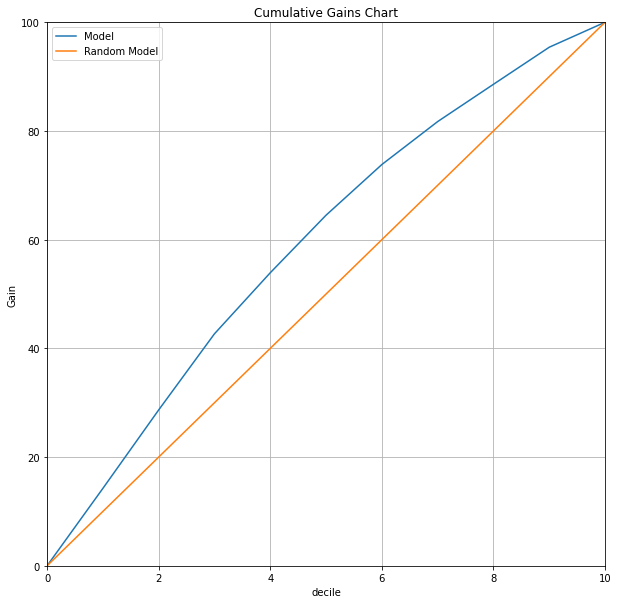

In [50]:
plt.figure(figsize=(10,10))
sns.lineplot(data=df_lift_test, x = "decile", y="Gain", label="Model").set_title('Cumulative Gains Chart')
sns.lineplot(data=df_lift_test, x = "decile", y="random_model", label="Random Model").set_title('Cumulative Gains Chart')
plt.ylim(0, 100)
plt.xlim(0, 10)
plt.grid()

## Check predictions

Aggregate model evaluation statistics, may not be applicable. Make sure predictions are strictly positive however

In [49]:
def test_statistics(y_test, y_pred_list_exp):
    mpd = mean_poisson_deviance(y_test, y_pred_list_exp)
    mse = mean_squared_error(y_test, y_pred_list_exp)
    r_square = r2_score(y_test, y_pred_list_exp)
    print("Mean Poisson Deviance :",mpd)
    print("Mean Squared Error :",mse)
    print("R^2 :",r_square)
    print(stats.describe(y_pred_list_exp))

test_statistics(y_test, y_pred_list_exp)    

Mean Poisson Deviance : 0.3184017812885004
Mean Squared Error : 0.05712786975413194
R^2 : 0.0029728446203978187
DescribeResult(nobs=135603, minmax=(0.00860232707047262, 0.41714129309526815), mean=0.05428001770603143, variance=0.0006625947473686832, skewness=1.4442920256206542, kurtosis=3.6516768815092346)


In [50]:
#TODO get full Poisson loss statistic function rather than sk-learn's average Poisson statistic

Basic checks on output

In [51]:
stats.describe(y_test)

DescribeResult(nobs=135603, minmax=(0.0, 4.0), mean=0.05364188107932715, variance=0.05729863097173327, skewness=4.772776171630065, kurtosis=25.86835613098223)

Glue test datasets back together

In [52]:
test_complete_data=np.column_stack((X_test, y_test))

Some dataframe manipulation

In [53]:
# get column names
dataframe_column_names=df_new_encoded.columns.tolist()
# get rid of ClaimNb
dataframe_column_names=dataframe_column_names[1:]
# add on ClaimNb at end
dataframe_column_names.append('ClaimNb')

Check column names

In [54]:
print(dataframe_column_names)

['Exposure', 'Area', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehGas', 'Density', 'VehBrand_B10', 'VehBrand_B11', 'VehBrand_B12', 'VehBrand_B13', 'VehBrand_B14', 'VehBrand_B2', 'VehBrand_B3', 'VehBrand_B4', 'VehBrand_B5', 'VehBrand_B6', 'Region_R21', 'Region_R22', 'Region_R23', 'Region_R24', 'Region_R25', 'Region_R26', 'Region_R31', 'Region_R41', 'Region_R42', 'Region_R43', 'Region_R52', 'Region_R53', 'Region_R54', 'Region_R72', 'Region_R73', 'Region_R74', 'Region_R82', 'Region_R83', 'Region_R91', 'Region_R93', 'Region_R94', 'ClaimNb']


Convert dataset of test data, actuals, and prediction back into dataframe

In [55]:
df_test=pd.DataFrame(data=test_complete_data,    # values
                     columns=dataframe_column_names)  # 1st row as the column names
df_test

,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehGas,Density,VehBrand_B10,VehBrand_B11,...,Region_R54,Region_R72,Region_R73,Region_R74,Region_R82,Region_R83,Region_R91,Region_R93,Region_R94,ClaimNb
0,1.00,0.4,0.181818,0.05,0.694444,0.00,2.0,0.515259,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.00,0.2,0.181818,0.65,0.444444,0.00,1.0,0.424432,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.05,0.4,0.272727,0.05,0.472222,0.12,1.0,0.478538,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.49,0.8,0.545455,0.00,0.222222,0.26,2.0,0.794506,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.07,0.4,0.090909,0.90,0.208333,0.00,2.0,0.605671,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135598,0.36,0.6,0.181818,0.00,0.569444,0.00,2.0,0.658020,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
135599,0.02,0.4,0.272727,0.00,0.708333,0.00,2.0,0.486382,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
135600,0.60,0.6,0.000000,0.30,0.402778,0.00,2.0,0.661754,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
135601,0.01,0.0,0.181818,0.10,0.763889,0.14,1.0,0.361528,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Reverse scaling

In [56]:
df_test[['Area', 'VehPower', 'VehAge','DrivAge','BonusMalus','Density']]=scaler.inverse_transform(df_test[['Area', 'VehPower', 'VehAge','DrivAge','BonusMalus','Density']] )
df_test

,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehGas,Density,VehBrand_B10,VehBrand_B11,...,Region_R54,Region_R72,Region_R73,Region_R74,Region_R82,Region_R83,Region_R91,Region_R93,Region_R94,ClaimNb
0,1.00,3.0,6.0,1.0,68.0,50.0,2.0,5.257495,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.00,2.0,6.0,13.0,50.0,50.0,1.0,4.330733,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.05,3.0,7.0,1.0,52.0,62.0,1.0,4.882802,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.49,5.0,10.0,0.0,34.0,76.0,2.0,8.106816,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.07,3.0,5.0,18.0,33.0,50.0,2.0,6.180017,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135598,0.36,4.0,6.0,0.0,59.0,50.0,2.0,6.714171,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
135599,0.02,3.0,7.0,0.0,69.0,50.0,2.0,4.962845,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
135600,0.60,4.0,4.0,6.0,47.0,50.0,2.0,6.752270,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
135601,0.01,1.0,6.0,2.0,73.0,64.0,1.0,3.688879,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Bin certain factors

We're going to examine certain factors, so let's first start by making a list

In [57]:
factor_list = ['Area', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehGas', 'Density']

For each factor we're going to add a binned version of the column. First let's define the bin size

In [58]:
BINSIZE = 15

Now let's loop round adding each binned factor

In [59]:
for i in factor_list:
    df_test[i+'_binned'] = pd.cut(df_test[i], bins=BINSIZE, duplicates='drop')

In [60]:
df_test

,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehGas,Density,VehBrand_B10,VehBrand_B11,...,Region_R93,Region_R94,ClaimNb,Area_binned,VehPower_binned,VehAge_binned,DrivAge_binned,BonusMalus_binned,VehGas_binned,Density_binned
0,1.00,3.0,6.0,1.0,68.0,50.0,2.0,5.257495,0.0,0.0,...,0.0,0.0,0.0,"(3.0, 3.333]","(5.467, 6.2]","(-0.02, 1.333]","(66.0, 70.8]","(49.9, 56.667]","(1.933, 2.0]","(5.131, 5.765]"
1,1.00,2.0,6.0,13.0,50.0,50.0,1.0,4.330733,0.0,0.0,...,0.0,0.0,0.0,"(1.667, 2.0]","(5.467, 6.2]","(12.0, 13.333]","(46.8, 51.6]","(49.9, 56.667]","(0.999, 1.067]","(3.863, 4.497]"
2,0.05,3.0,7.0,1.0,52.0,62.0,1.0,4.882802,0.0,0.0,...,0.0,0.0,0.0,"(3.0, 3.333]","(6.933, 7.667]","(-0.02, 1.333]","(51.6, 56.4]","(56.667, 63.333]","(0.999, 1.067]","(4.497, 5.131]"
3,0.49,5.0,10.0,0.0,34.0,76.0,2.0,8.106816,0.0,0.0,...,1.0,0.0,0.0,"(4.667, 5.0]","(9.867, 10.6]","(-0.02, 1.333]","(32.4, 37.2]","(70.0, 76.667]","(1.933, 2.0]","(7.667, 8.302]"
4,0.07,3.0,5.0,18.0,33.0,50.0,2.0,6.180017,0.0,0.0,...,0.0,0.0,0.0,"(3.0, 3.333]","(4.733, 5.467]","(17.333, 18.667]","(32.4, 37.2]","(49.9, 56.667]","(1.933, 2.0]","(5.765, 6.399]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135598,0.36,4.0,6.0,0.0,59.0,50.0,2.0,6.714171,0.0,0.0,...,0.0,0.0,0.0,"(3.667, 4.0]","(5.467, 6.2]","(-0.02, 1.333]","(56.4, 61.2]","(49.9, 56.667]","(1.933, 2.0]","(6.399, 7.033]"
135599,0.02,3.0,7.0,0.0,69.0,50.0,2.0,4.962845,0.0,0.0,...,0.0,0.0,0.0,"(3.0, 3.333]","(6.933, 7.667]","(-0.02, 1.333]","(66.0, 70.8]","(49.9, 56.667]","(1.933, 2.0]","(4.497, 5.131]"
135600,0.60,4.0,4.0,6.0,47.0,50.0,2.0,6.752270,0.0,0.0,...,0.0,0.0,0.0,"(3.667, 4.0]","(3.989, 4.733]","(5.333, 6.667]","(46.8, 51.6]","(49.9, 56.667]","(1.933, 2.0]","(6.399, 7.033]"
135601,0.01,1.0,6.0,2.0,73.0,64.0,1.0,3.688879,0.0,0.0,...,0.0,0.0,0.0,"(0.995, 1.333]","(5.467, 6.2]","(1.333, 2.667]","(70.8, 75.6]","(63.333, 70.0]","(0.999, 1.067]","(3.229, 3.863]"


## Add predictions on

In [61]:
df_test['ClaimNb_pred']=pd.Series(y_pred_list_exp)
df_test

,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehGas,Density,VehBrand_B10,VehBrand_B11,...,Region_R94,ClaimNb,Area_binned,VehPower_binned,VehAge_binned,DrivAge_binned,BonusMalus_binned,VehGas_binned,Density_binned,ClaimNb_pred
0,1.00,3.0,6.0,1.0,68.0,50.0,2.0,5.257495,0.0,0.0,...,0.0,0.0,"(3.0, 3.333]","(5.467, 6.2]","(-0.02, 1.333]","(66.0, 70.8]","(49.9, 56.667]","(1.933, 2.0]","(5.131, 5.765]",0.073959
1,1.00,2.0,6.0,13.0,50.0,50.0,1.0,4.330733,0.0,0.0,...,0.0,0.0,"(1.667, 2.0]","(5.467, 6.2]","(12.0, 13.333]","(46.8, 51.6]","(49.9, 56.667]","(0.999, 1.067]","(3.863, 4.497]",0.073541
2,0.05,3.0,7.0,1.0,52.0,62.0,1.0,4.882802,0.0,0.0,...,0.0,0.0,"(3.0, 3.333]","(6.933, 7.667]","(-0.02, 1.333]","(51.6, 56.4]","(56.667, 63.333]","(0.999, 1.067]","(4.497, 5.131]",0.063433
3,0.49,5.0,10.0,0.0,34.0,76.0,2.0,8.106816,0.0,0.0,...,0.0,0.0,"(4.667, 5.0]","(9.867, 10.6]","(-0.02, 1.333]","(32.4, 37.2]","(70.0, 76.667]","(1.933, 2.0]","(7.667, 8.302]",0.038767
4,0.07,3.0,5.0,18.0,33.0,50.0,2.0,6.180017,0.0,0.0,...,0.0,0.0,"(3.0, 3.333]","(4.733, 5.467]","(17.333, 18.667]","(32.4, 37.2]","(49.9, 56.667]","(1.933, 2.0]","(5.765, 6.399]",0.014309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135598,0.36,4.0,6.0,0.0,59.0,50.0,2.0,6.714171,0.0,0.0,...,0.0,0.0,"(3.667, 4.0]","(5.467, 6.2]","(-0.02, 1.333]","(56.4, 61.2]","(49.9, 56.667]","(1.933, 2.0]","(6.399, 7.033]",0.034907
135599,0.02,3.0,7.0,0.0,69.0,50.0,2.0,4.962845,0.0,0.0,...,0.0,0.0,"(3.0, 3.333]","(6.933, 7.667]","(-0.02, 1.333]","(66.0, 70.8]","(49.9, 56.667]","(1.933, 2.0]","(4.497, 5.131]",0.030016
135600,0.60,4.0,4.0,6.0,47.0,50.0,2.0,6.752270,0.0,0.0,...,0.0,0.0,"(3.667, 4.0]","(3.989, 4.733]","(5.333, 6.667]","(46.8, 51.6]","(49.9, 56.667]","(1.933, 2.0]","(6.399, 7.033]",0.037889
135601,0.01,1.0,6.0,2.0,73.0,64.0,1.0,3.688879,0.0,0.0,...,0.0,0.0,"(0.995, 1.333]","(5.467, 6.2]","(1.333, 2.667]","(70.8, 75.6]","(63.333, 70.0]","(0.999, 1.067]","(3.229, 3.863]",0.040952


In [ ]:
df_sum=df_test.groupby([FACTOR+'_binned'])['Exposure','ClaimNb', 'ClaimNb_pred'].sum().reset_index()

## One way analysis

Let's pick a factor to dive into

In [62]:
FACTOR = 'VehAge'

Aggregate test data to look at by factor

In [63]:
df_sum=df_test.groupby([FACTOR+'_binned'])['Exposure','ClaimNb', 'ClaimNb_pred'].sum().reset_index()

c:\Users\dylan\anaconda3\envs\pysyft2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


We'll make a function to convert claims into frequencies, and add the mid-point of the chosen factors bins for graphing purposes

In [64]:
def frequency_conversion(df, freq_dictionary):
    for key in freq_dictionary:
        df[freq_dictionary[key]]=df[key]/df['Exposure']

    df.insert(1,FACTOR+'_binned_midpoint',[round((a.left + a.right)/2,0) for a in df[FACTOR+'_binned']])

Now use to the function to convert claims into claim frequencies

In [65]:
frequency_conversion(df_sum, {'ClaimNb':'freq', 'ClaimNb_pred':'freq_pred', 'ClaimNb_pred':'freq_pred'})
df_sum

,VehAge_binned,VehAge_binned_midpoint,Exposure,ClaimNb,ClaimNb_pred,freq,freq_pred
0,"(-0.02, 1.333]",1.0,9838.357316,1611.0,1548.553933,0.163747,0.157400
1,"(1.333, 2.667]",2.0,5907.466520,566.0,732.127985,0.095811,0.123933
2,"(2.667, 4.0]",3.0,9970.075603,906.0,1140.559605,0.090872,0.114398
3,"(4.0, 5.333]",5.0,4500.586535,439.0,473.337456,0.097543,0.105172
4,"(5.333, 6.667]",6.0,4167.076640,446.0,417.930140,0.107029,0.100293
5,"(6.667, 8.0]",7.0,7657.941897,806.0,718.417517,0.105250,0.093813
6,"(8.0, 9.333]",9.0,3773.385409,390.0,332.768882,0.103355,0.088188
7,"(9.333, 10.667]",10.0,4213.344039,424.0,381.060993,0.100633,0.090441
8,"(10.667, 12.0]",11.0,3482.062951,318.0,284.330547,0.091325,0.081656
9,"(12.0, 13.333]",13.0,6643.217003,570.0,520.259615,0.085802,0.078314


## Graph

We'll also make a function to produce one-way analysis graphs

In [66]:
def one_way_graph(df, *freq):
    data_preproc = df[[FACTOR+'_binned_midpoint', *freq]]
    plt.figure(figsize=(15,8))
    sns.lineplot(data=pd.melt(data_preproc, [FACTOR+'_binned_midpoint']), x=FACTOR+'_binned_midpoint', y='value', hue='variable')

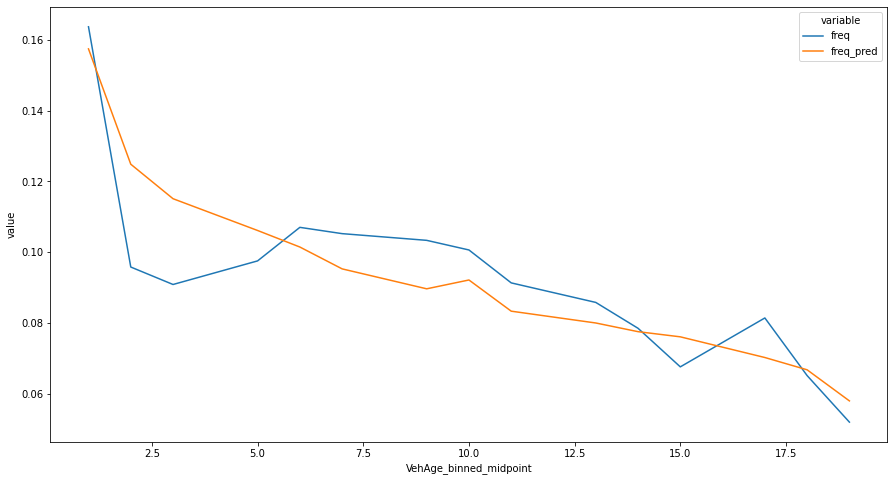

In [61]:
one_way_graph(df_sum, 'freq', 'freq_pred')

# Repeat same exercise BUT with data truncated

# Partial model hyperparameters

In [62]:
partial_params = run_study(eval('train_loader_' + str(SELECTED_AGENT)), eval('val_loader_' + str(SELECTED_AGENT)))

[I 2021-08-04 18:35:57,458] A new study created in memory with name: no-name-9371f39b-0b50-4929-8006-6156b3ec4475
[I 2021-08-04 18:37:05,354] Trial 0 finished with value: 0.6320389554695746 and parameters: {'n_layers': 1, 'n_units_l0': 74, 'dropout_0': 0.10510302568647063, 'optimizer': 'SGD', 'lr': 0.00016284517455378102}. Best is trial 0 with value: 0.6320389554695746.
[I 2021-08-04 18:38:13,303] Trial 1 finished with value: 0.30923286873358236 and parameters: {'n_layers': 1, 'n_units_l0': 31, 'dropout_0': 0.12409392594394411, 'optimizer': 'Adam', 'lr': 6.888528294546944e-05}. Best is trial 1 with value: 0.30923286873358236.
[I 2021-08-04 18:39:21,222] Trial 2 finished with value: 0.740936326406962 and parameters: {'n_layers': 1, 'n_units_l0': 68, 'dropout_0': 0.16197858237222895, 'optimizer': 'Adam', 'lr': 1.2204712441306537e-05}. Best is trial 1 with value: 0.30923286873358236.
[I 2021-08-04 18:40:39,710] Trial 3 finished with value: 0.8160758542561777 and parameters: {'n_layers': 2

Study statistics: 
  Number of finished trials:  4
  Number of pruned trials:  0
  Number of complete trials:  4
Best trial:
  Value:  0.30923286873358236
  Params: 
    n_layers: 1
    n_units_l0: 31
    dropout_0: 0.12409392594394411
    optimizer: Adam
    lr: 6.888528294546944e-05


Check

In [63]:
partial_params["lr"]

6.888528294546944e-05

Remember to choose if using global or partial network

In [67]:
LEARNING_RATE_PARTIAL = 6.888528294546944e-05

Create a new model to train

In [68]:
model_partial = MultipleRegression(NUM_FEATURES)
model_partial.to(device)
print(model_partial)

MultipleRegression(
  (layer_1): Linear(in_features=39, out_features=31, bias=True)
  (layer_out): Linear(in_features=31, out_features=1, bias=True)
  (dropout_1): Dropout(p=0.12409392594394411, inplace=False)
  (relu): ReLU()
)


Set optimiser to best one found by Optuna

In [69]:
optimizer_partial = optim.Adam(model_partial.parameters(), lr=LEARNING_RATE_PARTIAL) 

# Same training loop (but with partial model and partial data)

In [70]:
model_partial, loss_stats_partial = training_loop(model_partial, eval('train_loader_' + str(SELECTED_AGENT)), eval('val_loader_' + str(SELECTED_AGENT)), optimizer_partial)

Begin training.


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.91330 | Val Loss: 0.89206
Epoch 002: | Train Loss: 0.87391 | Val Loss: 0.85385
Epoch 003: | Train Loss: 0.83676 | Val Loss: 0.81718
Epoch 004: | Train Loss: 0.80077 | Val Loss: 0.78078
Epoch 005: | Train Loss: 0.76455 | Val Loss: 0.74423
Epoch 006: | Train Loss: 0.72781 | Val Loss: 0.70732
Epoch 007: | Train Loss: 0.69098 | Val Loss: 0.67005
Epoch 008: | Train Loss: 0.65398 | Val Loss: 0.63280
Epoch 009: | Train Loss: 0.61757 | Val Loss: 0.59597
Epoch 010: | Train Loss: 0.58107 | Val Loss: 0.56035
Epoch 011: | Train Loss: 0.54691 | Val Loss: 0.52677
Epoch 012: | Train Loss: 0.51468 | Val Loss: 0.49573
Epoch 013: | Train Loss: 0.48540 | Val Loss: 0.46738
Epoch 014: | Train Loss: 0.45832 | Val Loss: 0.44167
Epoch 015: | Train Loss: 0.43441 | Val Loss: 0.41836
Epoch 016: | Train Loss: 0.41313 | Val Loss: 0.39734
Epoch 017: | Train Loss: 0.39310 | Val Loss: 0.37840
Epoch 018: | Train Loss: 0.37547 | Val Loss: 0.36126
Epoch 019: | Train Loss: 0.35948 | Val Loss: 0

## Visualize Training Loss

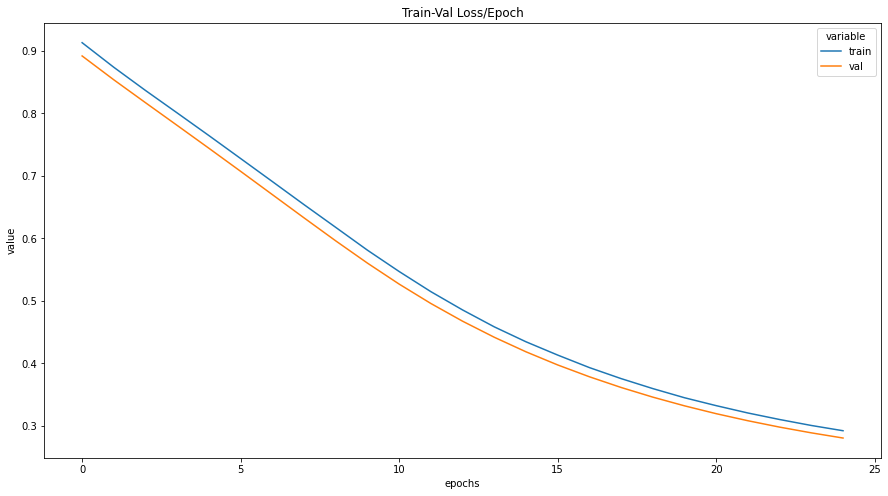

In [71]:
training_graph(loss_stats_partial)

Model doesn't appear to have converged. Realistically an agent would be unlikely to stop training here - however to make the comparison fair all models should ideally have the same parameters (epochs, layers etc.).

As a balancing compromise between making the comparison completely like-for-like, and realistic, we'll give the agent another 25 epochs (double the global and federated model) for their weights to converge. 

So although the agent has a lot LESS data, they do get more training time.

Lets repeat the setup to wipe any old weights, biases etc. just in case

In [72]:
model_partial = MultipleRegression(NUM_FEATURES)
model_partial.to(device)
optimizer_partial = optim.Adam(model_partial.parameters(), lr=LEARNING_RATE_PARTIAL)

And again the same training loop but with an extra 25 epochs

In [73]:
model_partial, loss_stats_partial = training_loop(model_partial, eval('train_loader_' + str(SELECTED_AGENT)), eval('val_loader_' + str(SELECTED_AGENT)), optimizer_partial, epochs=EPOCHS+25)

Begin training.


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.07813 | Val Loss: 1.06226
Epoch 002: | Train Loss: 1.04597 | Val Loss: 1.02970
Epoch 003: | Train Loss: 1.01317 | Val Loss: 0.99544
Epoch 004: | Train Loss: 0.97786 | Val Loss: 0.95853
Epoch 005: | Train Loss: 0.93971 | Val Loss: 0.91840
Epoch 006: | Train Loss: 0.89831 | Val Loss: 0.87493
Epoch 007: | Train Loss: 0.85335 | Val Loss: 0.82842
Epoch 008: | Train Loss: 0.80621 | Val Loss: 0.77962
Epoch 009: | Train Loss: 0.75750 | Val Loss: 0.72996
Epoch 010: | Train Loss: 0.70842 | Val Loss: 0.68096
Epoch 011: | Train Loss: 0.66080 | Val Loss: 0.63374
Epoch 012: | Train Loss: 0.61497 | Val Loss: 0.58918
Epoch 013: | Train Loss: 0.57286 | Val Loss: 0.54783
Epoch 014: | Train Loss: 0.53330 | Val Loss: 0.51010
Epoch 015: | Train Loss: 0.49848 | Val Loss: 0.47635
Epoch 016: | Train Loss: 0.46637 | Val Loss: 0.44634
Epoch 017: | Train Loss: 0.43848 | Val Loss: 0.41979
Epoch 018: | Train Loss: 0.41368 | Val Loss: 0.39631
Epoch 019: | Train Loss: 0.39179 | Val Loss: 0

## Visualize Training Loss after allowing more training time

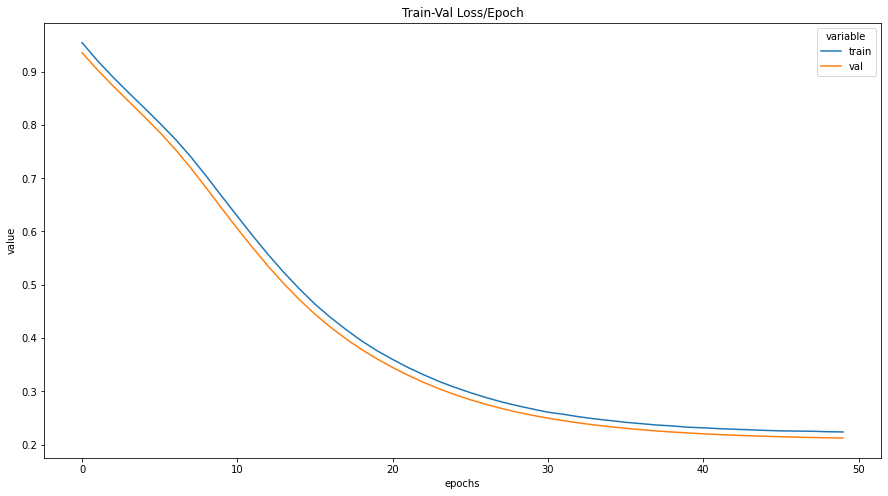

In [71]:
training_graph(loss_stats_partial)

Noticably better!

## Testing the partial model

Exponentiate the results as before and check the output

In [74]:
y_partial_pred_list_exp = exp_model_predictions(model_partial)
test_statistics(y_test, y_partial_pred_list_exp)    

Mean Poisson Deviance : 0.3398881299852942
Mean Squared Error : 0.058700908969839274
R^2 : -0.02448070513188938
DescribeResult(nobs=135603, minmax=(0.018913311192265348, 0.29332591588141166), mean=0.07347336907826486, variance=0.0007205261655131681, skewness=1.1120183265798405, kurtosis=1.8885875359498057)


In [97]:
df_preds_l_exp = pd.DataFrame(y_partial_pred_list_exp, columns=['exp'])
#df_preds_l_exp
df_preds_l_exp_sorted = df_preds_l_exp.sort_values(by='exp', ascending = False)
#df_preds_l_exp_sorted
df_preds_l_exp_sorted['Decile'] = pd.qcut(df_preds_l_exp_sorted ['exp'], 10, labels=[i for i in range (10, 0, -1)])
df_preds_l_vs_act = pd.concat([df_act, df_preds_l_exp_sorted], axis=1, join="inner")
#df_preds_l_vs_act
df_lift = df_preds_l_vs_act.groupby(['Decile'])['act', 'exp'].sum().reset_index()
df_lift
#df_lift.to_csv('lift3.csv', index=False)

c:\Users\dylan\anaconda3\envs\pysyft2\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,Decile,act,exp
0,10,1036.0,519.727852
1,9,825.0,646.453648
2,8,776.0,730.926190
3,7,694.0,808.712883
4,6,622.0,888.345116
5,5,625.0,973.534845
6,4,686.0,1071.302933
7,3,659.0,1192.757216
8,2,637.0,1365.492656
9,1,714.0,1765.955929


Add partial predictions on test dataframe

In [73]:
df_test['ClaimNb_partial_pred']=pd.Series(y_partial_pred_list_exp)
df_test

,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehGas,Density,VehBrand_B10,VehBrand_B11,...,ClaimNb,Area_binned,VehPower_binned,VehAge_binned,DrivAge_binned,BonusMalus_binned,VehGas_binned,Density_binned,ClaimNb_pred,ClaimNb_partial_pred
0,1.00,3.0,6.0,1.0,68.0,50.0,2.0,5.257495,0.0,0.0,...,0.0,"(3.0, 3.333]","(5.467, 6.2]","(-0.02, 1.333]","(66.0, 70.8]","(49.9, 56.667]","(1.933, 2.0]","(5.131, 5.765]",0.079355,0.068656
1,1.00,2.0,6.0,13.0,50.0,50.0,1.0,4.330733,0.0,0.0,...,0.0,"(1.667, 2.0]","(5.467, 6.2]","(12.0, 13.333]","(46.8, 51.6]","(49.9, 56.667]","(0.999, 1.067]","(3.863, 4.497]",0.072059,0.095305
2,0.05,3.0,7.0,1.0,52.0,62.0,1.0,4.882802,0.0,0.0,...,0.0,"(3.0, 3.333]","(6.933, 7.667]","(-0.02, 1.333]","(51.6, 56.4]","(56.667, 63.333]","(0.999, 1.067]","(4.497, 5.131]",0.059004,0.107570
3,0.49,5.0,10.0,0.0,34.0,76.0,2.0,8.106816,0.0,0.0,...,0.0,"(4.667, 5.0]","(9.867, 10.6]","(-0.02, 1.333]","(32.4, 37.2]","(70.0, 76.667]","(1.933, 2.0]","(7.667, 8.302]",0.045388,0.039391
4,0.07,3.0,5.0,18.0,33.0,50.0,2.0,6.180017,0.0,0.0,...,0.0,"(3.0, 3.333]","(4.733, 5.467]","(17.333, 18.667]","(32.4, 37.2]","(49.9, 56.667]","(1.933, 2.0]","(5.765, 6.399]",0.014149,0.056639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135598,0.36,4.0,6.0,0.0,59.0,50.0,2.0,6.714171,0.0,0.0,...,0.0,"(3.667, 4.0]","(5.467, 6.2]","(-0.02, 1.333]","(56.4, 61.2]","(49.9, 56.667]","(1.933, 2.0]","(6.399, 7.033]",0.035105,0.058893
135599,0.02,3.0,7.0,0.0,69.0,50.0,2.0,4.962845,0.0,0.0,...,0.0,"(3.0, 3.333]","(6.933, 7.667]","(-0.02, 1.333]","(66.0, 70.8]","(49.9, 56.667]","(1.933, 2.0]","(4.497, 5.131]",0.030819,0.070553
135600,0.60,4.0,4.0,6.0,47.0,50.0,2.0,6.752270,0.0,0.0,...,0.0,"(3.667, 4.0]","(3.989, 4.733]","(5.333, 6.667]","(46.8, 51.6]","(49.9, 56.667]","(1.933, 2.0]","(6.399, 7.033]",0.039918,0.051834
135601,0.01,1.0,6.0,2.0,73.0,64.0,1.0,3.688879,0.0,0.0,...,0.0,"(0.995, 1.333]","(5.467, 6.2]","(1.333, 2.667]","(70.8, 75.6]","(63.333, 70.0]","(0.999, 1.067]","(3.229, 3.863]",0.041055,0.111134


Sum up the data and convert to claim frequencies as before

In [74]:
df_partial_sum=df_test.groupby([FACTOR+'_binned'])['Exposure','ClaimNb', 'ClaimNb_pred', 'ClaimNb_partial_pred'].sum().reset_index()
frequency_conversion(df_partial_sum, {'ClaimNb':'freq', 'ClaimNb_pred':'freq_pred', 'ClaimNb_pred':'freq_pred', 'ClaimNb_partial_pred':'freq_partial_pred'})
df_partial_sum

C:\Users\dylan\anaconda3\envs\pysyft2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,VehAge_binned,VehAge_binned_midpoint,Exposure,ClaimNb,ClaimNb_pred,ClaimNb_partial_pred,freq,freq_pred,freq_partial_pred
0,"(-0.02, 1.333]",1.0,9838.357316,1611.0,1549.539746,2030.751726,0.163747,0.157500,0.206412
1,"(1.333, 2.667]",2.0,5907.466520,566.0,737.752020,907.650012,0.095811,0.124885,0.153645
2,"(2.667, 4.0]",3.0,9970.075603,906.0,1147.825208,1425.308457,0.090872,0.115127,0.142959
3,"(4.0, 5.333]",5.0,4500.586535,439.0,477.706902,587.922147,0.097543,0.106143,0.130632
4,"(5.333, 6.667]",6.0,4167.076640,446.0,422.814888,531.332258,0.107029,0.101466,0.127507
5,"(6.667, 8.0]",7.0,7657.941897,806.0,729.698047,943.667948,0.105250,0.095286,0.123227
6,"(8.0, 9.333]",9.0,3773.385409,390.0,338.281008,458.949664,0.103355,0.089649,0.121628
7,"(9.333, 10.667]",10.0,4213.344039,424.0,388.237395,545.384653,0.100633,0.092145,0.129442
8,"(10.667, 12.0]",11.0,3482.062951,318.0,290.147201,412.685516,0.091325,0.083326,0.118518
9,"(12.0, 13.333]",13.0,6643.217003,570.0,531.369410,785.358911,0.085802,0.079987,0.118220


## Graph and compare

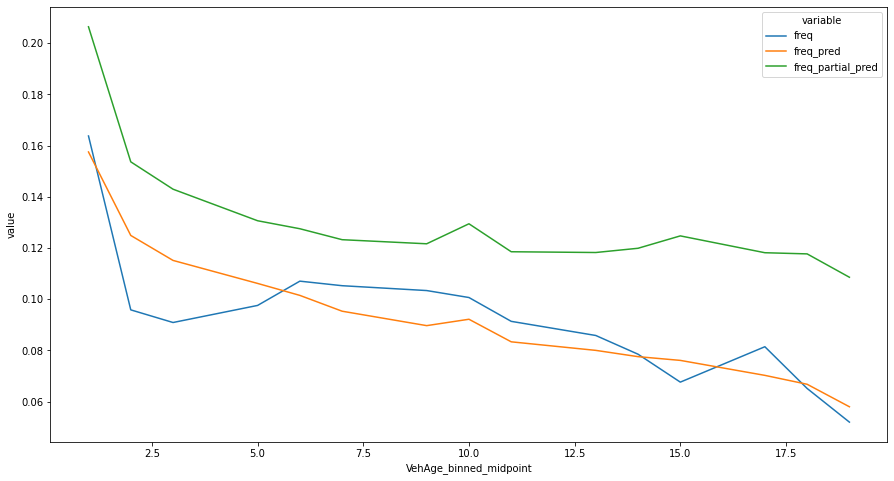

In [75]:
one_way_graph(df_partial_sum, 'freq', 'freq_pred', 'freq_partial_pred')

**Should notice that when only using partial data the fit is not as good**

# Introduce Federated Learning

## Make agents and distrubte data

In [76]:
#clear agents
#Agent1=Agent1.clear_objects()
#Agent2=Agent2.clear_objects()
#secure_worker=secure_worker.clear_objects()
Agent0 = sy.VirtualWorker(hook, id="Agent0")
Agent1 = sy.VirtualWorker(hook, id="Agent1")
Agent2 = sy.VirtualWorker(hook, id="Agent2")
Agent3 = sy.VirtualWorker(hook, id="Agent3")
Agent4 = sy.VirtualWorker(hook, id="Agent4")
Agent5 = sy.VirtualWorker(hook, id="Agent5")
Agent6 = sy.VirtualWorker(hook, id="Agent6")
Agent7 = sy.VirtualWorker(hook, id="Agent7")
Agent8 = sy.VirtualWorker(hook, id="Agent8")
Agent9 = sy.VirtualWorker(hook, id="Agent9")
secure_worker = sy.VirtualWorker(hook, id="secure_worker")

Check pointers to tensors are setup

In [77]:
print("Agent1 has: " + str(Agent1._objects))
print("Agent2 has: " + str(Agent2._objects))
print("Secure_worker has: " + str(secure_worker._objects))

Agent1 has: {}
Agent2 has: {}
Secure_worker has: {}


Convert data to PyTorch tensors

In [78]:
X_train_tensor_0 = th.from_numpy(X_train_0).float()
X_train_tensor_1 = th.from_numpy(X_train_1).float()
X_train_tensor_2 = th.from_numpy(X_train_2).float()
X_train_tensor_3 = th.from_numpy(X_train_3).float()
X_train_tensor_4 = th.from_numpy(X_train_4).float()
X_train_tensor_5 = th.from_numpy(X_train_5).float()
X_train_tensor_6 = th.from_numpy(X_train_6).float()
X_train_tensor_7 = th.from_numpy(X_train_7).float()
X_train_tensor_8 = th.from_numpy(X_train_8).float()
X_train_tensor_9 = th.from_numpy(X_train_9).float()

y_train_tensor_0 = th.from_numpy(y_train_0).float()
y_train_tensor_1 = th.from_numpy(y_train_1).float()
y_train_tensor_2 = th.from_numpy(y_train_2).float()
y_train_tensor_3 = th.from_numpy(y_train_3).float()
y_train_tensor_4 = th.from_numpy(y_train_4).float()
y_train_tensor_5 = th.from_numpy(y_train_5).float()
y_train_tensor_6 = th.from_numpy(y_train_6).float()
y_train_tensor_7 = th.from_numpy(y_train_7).float()
y_train_tensor_8 = th.from_numpy(y_train_8).float()
y_train_tensor_9 = th.from_numpy(y_train_9).float()

Splits training data into agents

In [79]:
Agent0_train_data = sy.BaseDataset(X_train_tensor_0, y_train_tensor_0).send(Agent0)
Agent1_train_data = sy.BaseDataset(X_train_tensor_1, y_train_tensor_1).send(Agent1)
Agent2_train_data = sy.BaseDataset(X_train_tensor_2, y_train_tensor_2).send(Agent2)
Agent3_train_data = sy.BaseDataset(X_train_tensor_3, y_train_tensor_3).send(Agent3)
Agent4_train_data = sy.BaseDataset(X_train_tensor_4, y_train_tensor_4).send(Agent4)
Agent5_train_data = sy.BaseDataset(X_train_tensor_5, y_train_tensor_5).send(Agent5)
Agent6_train_data = sy.BaseDataset(X_train_tensor_6, y_train_tensor_6).send(Agent6)
Agent7_train_data = sy.BaseDataset(X_train_tensor_7, y_train_tensor_7).send(Agent7)
Agent8_train_data = sy.BaseDataset(X_train_tensor_8, y_train_tensor_8).send(Agent8)
Agent9_train_data = sy.BaseDataset(X_train_tensor_9, y_train_tensor_9).send(Agent9)

Create federated train loaders

In [80]:
federated_train_dataset = sy.FederatedDataset([Agent0_train_data, Agent1_train_data, Agent2_train_data, Agent3_train_data, Agent4_train_data, Agent5_train_data, Agent6_train_data, Agent7_train_data, Agent8_train_data, Agent9_train_data])
federated_train_loader = sy.FederatedDataLoader(federated_train_dataset, shuffle=True, batch_size=BATCH_SIZE)

Check pointers to tensors and data are working

In [81]:
print(Agent1_train_data.data)
print(Agent2_train_data.data)

(Wrapper)>[PointerTensor | me:48140073444 -> Agent1:48605864017]
(Wrapper)>[PointerTensor | me:91180721483 -> Agent2:18435564713]


In [82]:
print(federated_train_dataset)

FederatedDataset
    Distributed accross: Agent0, Agent1, Agent2, Agent3, Agent4, Agent5, Agent6, Agent7, Agent8, Agent9
    Number of datapoints: 488169



# Federated Model Training

Create a new model to train

In [83]:
model_fl = MultipleRegression(NUM_FEATURES)
model_fl.to(device)
print(model_fl)

MultipleRegression(
  (layer_1): Linear(in_features=39, out_features=31, bias=True)
  (layer_out): Linear(in_features=31, out_features=1, bias=True)
  (dropout_1): Dropout(p=0.12409392594394411, inplace=False)
  (relu): ReLU()
)


Note now we need an optimizer for EACH agent

In [84]:
#TODO make optimizer pick up best from Optuna

In [85]:
optimizers_fl = {}
for worker in {Agent0, Agent1, Agent2, Agent3, Agent4, Agent5, Agent6, Agent7, Agent8, Agent9}:
    optimizers_fl[worker.id] = th.optim.Adam(params=model_fl.parameters(),lr=LEARNING_RATE)


Create another dictionary for losses

In [86]:
loss_stats_fl = {
    'train': [],
    "val": []
}

## Commence Federated Training Loop

Note we need to add:
1. `agent = X_train_batch.location.id`
2. `model_fl.send(X_train_batch.location)`
3. `optimizer_fl = optimizers_fl[agent]`
4. `model_fl.get()`
5. `train_loss = train_loss.get()`

to the loop so we don't use the training function we wrote earlier. However, you can see *PySyft* only needs a few modications to standard *PyTorch* code to run

In [87]:
# Training loop
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    # change model
    model_fl.train()
    # change loader to federated data loader
    for X_train_batch, y_train_batch in federated_train_loader:
        # send the model to the client device where the data is present
        agent = X_train_batch.location.id
        model_fl.send(X_train_batch.location)
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)

        optimizer_fl = optimizers_fl[agent]
        # change optimizer
        optimizer_fl.zero_grad()
        # change model
        y_train_pred = model_fl(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        #change optimizer
        train_loss.backward()
        optimizer_fl.step()


        # get back the improved model
        model_fl.get()
        train_loss = train_loss.get()
        
        train_epoch_loss += train_loss.item()
        
    # VALIDATION    
    #with th.no_grad():
        
        #val_epoch_loss = 0
        #change model
        #model_fl.eval()
        #change loader
        #for X_val_batch, y_val_batch in val_partial_loader:
            #X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            #change model
            #y_val_pred = model_fl(X_val_batch)
                        
            #val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            
            #val_epoch_loss += val_loss.item()
    #change loader although only using len sk shouldn't make a difference
    loss_stats_fl['train'].append(train_epoch_loss/len(federated_train_loader))
    #loss_stats_fl['val'].append(val_epoch_loss/len(val_loader))                              
    #change loader although only using len sk shouldn't make a difference
    #print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(federated_train_loader):.5f}')

Begin training.


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.76871
Epoch 002: | Train Loss: 0.47623
Epoch 003: | Train Loss: 0.30381
Epoch 004: | Train Loss: 0.24159
Epoch 005: | Train Loss: 0.22468
Epoch 006: | Train Loss: 0.22059
Epoch 007: | Train Loss: 0.21954
Epoch 008: | Train Loss: 0.21916
Epoch 009: | Train Loss: 0.21864
Epoch 010: | Train Loss: 0.21786
Epoch 011: | Train Loss: 0.21748
Epoch 012: | Train Loss: 0.21679
Epoch 013: | Train Loss: 0.21635
Epoch 014: | Train Loss: 0.21572
Epoch 015: | Train Loss: 0.21536
Epoch 016: | Train Loss: 0.21473
Epoch 017: | Train Loss: 0.21425
Epoch 018: | Train Loss: 0.21420
Epoch 019: | Train Loss: 0.21344
Epoch 020: | Train Loss: 0.21327
Epoch 021: | Train Loss: 0.21303
Epoch 022: | Train Loss: 0.21249
Epoch 023: | Train Loss: 0.21251
Epoch 024: | Train Loss: 0.21220
Epoch 025: | Train Loss: 0.21191


Note including validation tests increases run time **significantly** and for our purposes wouldn't change the outcome. We'll see later the model doesn't show signs of overfitting

## Visualize Training Loss

We need to delete the `val` column from the `loss_stats_fl` dictionary **IF** it wasn't used i.e. when `len(loss_stats_fl['val']) == 0`. Otherwise *Pandas* won't be able to convert it into a dataframe (as the length of the `train` column won't be the same as `val`).

In [88]:
if len(loss_stats_fl['val']) == 0:
    del loss_stats_fl['val']

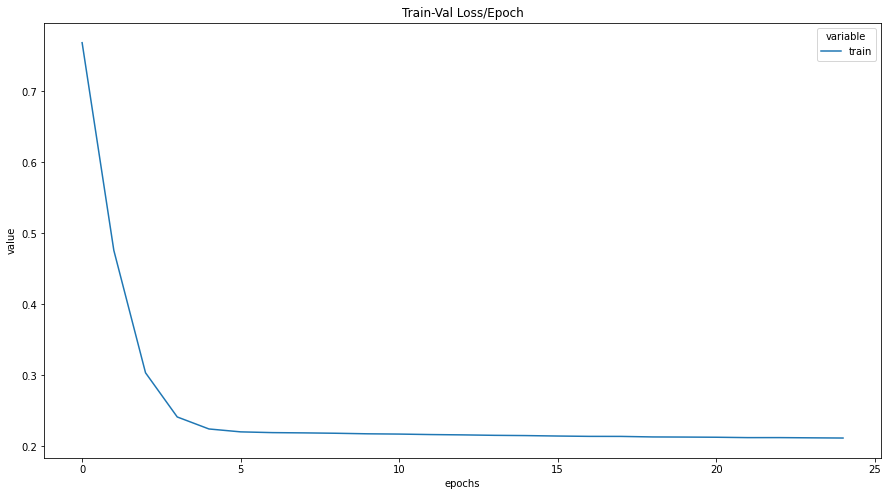

In [89]:
training_graph(loss_stats_fl)

Should show no signs of overfitting again

## Test the federated model as per last time

Exponentiate and do some basic checks again

In [90]:
y_fl_pred_list_exp = exp_model_predictions(model_fl)
test_statistics(y_test, y_fl_pred_list_exp)

Mean Poisson Deviance : 0.3195655924948312
Mean Squared Error : 0.05718794024689923
R^2 : 0.001924461181915249
DescribeResult(nobs=135603, minmax=(0.011138397658008165, 0.22659253934279627), mean=0.05446308087370055, variance=0.0005114638866566755, skewness=1.129438481208655, kurtosis=1.852763643404833)


Again add on to test dataframe

In [91]:
df_test['ClaimNb_fl_pred']=pd.Series(y_fl_pred_list_exp)
df_test

,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehGas,Density,VehBrand_B10,VehBrand_B11,...,Area_binned,VehPower_binned,VehAge_binned,DrivAge_binned,BonusMalus_binned,VehGas_binned,Density_binned,ClaimNb_pred,ClaimNb_partial_pred,ClaimNb_fl_pred
0,1.00,3.0,6.0,1.0,68.0,50.0,2.0,5.257495,0.0,0.0,...,"(3.0, 3.333]","(5.467, 6.2]","(-0.02, 1.333]","(66.0, 70.8]","(49.9, 56.667]","(1.933, 2.0]","(5.131, 5.765]",0.079355,0.068656,0.066666
1,1.00,2.0,6.0,13.0,50.0,50.0,1.0,4.330733,0.0,0.0,...,"(1.667, 2.0]","(5.467, 6.2]","(12.0, 13.333]","(46.8, 51.6]","(49.9, 56.667]","(0.999, 1.067]","(3.863, 4.497]",0.072059,0.095305,0.078216
2,0.05,3.0,7.0,1.0,52.0,62.0,1.0,4.882802,0.0,0.0,...,"(3.0, 3.333]","(6.933, 7.667]","(-0.02, 1.333]","(51.6, 56.4]","(56.667, 63.333]","(0.999, 1.067]","(4.497, 5.131]",0.059004,0.107570,0.063966
3,0.49,5.0,10.0,0.0,34.0,76.0,2.0,8.106816,0.0,0.0,...,"(4.667, 5.0]","(9.867, 10.6]","(-0.02, 1.333]","(32.4, 37.2]","(70.0, 76.667]","(1.933, 2.0]","(7.667, 8.302]",0.045388,0.039391,0.037434
4,0.07,3.0,5.0,18.0,33.0,50.0,2.0,6.180017,0.0,0.0,...,"(3.0, 3.333]","(4.733, 5.467]","(17.333, 18.667]","(32.4, 37.2]","(49.9, 56.667]","(1.933, 2.0]","(5.765, 6.399]",0.014149,0.056639,0.017790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135598,0.36,4.0,6.0,0.0,59.0,50.0,2.0,6.714171,0.0,0.0,...,"(3.667, 4.0]","(5.467, 6.2]","(-0.02, 1.333]","(56.4, 61.2]","(49.9, 56.667]","(1.933, 2.0]","(6.399, 7.033]",0.035105,0.058893,0.033074
135599,0.02,3.0,7.0,0.0,69.0,50.0,2.0,4.962845,0.0,0.0,...,"(3.0, 3.333]","(6.933, 7.667]","(-0.02, 1.333]","(66.0, 70.8]","(49.9, 56.667]","(1.933, 2.0]","(4.497, 5.131]",0.030819,0.070553,0.030684
135600,0.60,4.0,4.0,6.0,47.0,50.0,2.0,6.752270,0.0,0.0,...,"(3.667, 4.0]","(3.989, 4.733]","(5.333, 6.667]","(46.8, 51.6]","(49.9, 56.667]","(1.933, 2.0]","(6.399, 7.033]",0.039918,0.051834,0.037715
135601,0.01,1.0,6.0,2.0,73.0,64.0,1.0,3.688879,0.0,0.0,...,"(0.995, 1.333]","(5.467, 6.2]","(1.333, 2.667]","(70.8, 75.6]","(63.333, 70.0]","(0.999, 1.067]","(3.229, 3.863]",0.041055,0.111134,0.043702


Sum and convert into frequencies

In [92]:
df_fl_sum=df_test.groupby([FACTOR+'_binned'])['Exposure','ClaimNb', 'ClaimNb_pred', 'ClaimNb_partial_pred', 'ClaimNb_fl_pred'].sum().reset_index()
frequency_conversion(df_fl_sum, {'ClaimNb':'freq', 'ClaimNb_pred':'freq_pred', 'ClaimNb_pred':'freq_pred', 'ClaimNb_partial_pred':'freq_partial_pred', 'ClaimNb_fl_pred':'freq_fl_pred'})
df_fl_sum

C:\Users\dylan\anaconda3\envs\pysyft2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,VehAge_binned,VehAge_binned_midpoint,Exposure,ClaimNb,ClaimNb_pred,ClaimNb_partial_pred,ClaimNb_fl_pred,freq,freq_pred,freq_partial_pred,freq_fl_pred
0,"(-0.02, 1.333]",1.0,9838.357316,1611.0,1549.539746,2030.751726,1495.044526,0.163747,0.157500,0.206412,0.151961
1,"(1.333, 2.667]",2.0,5907.466520,566.0,737.752020,907.650012,705.603642,0.095811,0.124885,0.153645,0.119443
2,"(2.667, 4.0]",3.0,9970.075603,906.0,1147.825208,1425.308457,1109.842255,0.090872,0.115127,0.142959,0.111317
3,"(4.0, 5.333]",5.0,4500.586535,439.0,477.706902,587.922147,463.997871,0.097543,0.106143,0.130632,0.103097
4,"(5.333, 6.667]",6.0,4167.076640,446.0,422.814888,531.332258,413.446551,0.107029,0.101466,0.127507,0.099217
5,"(6.667, 8.0]",7.0,7657.941897,806.0,729.698047,943.667948,720.294497,0.105250,0.095286,0.123227,0.094058
6,"(8.0, 9.333]",9.0,3773.385409,390.0,338.281008,458.949664,339.667921,0.103355,0.089649,0.121628,0.090017
7,"(9.333, 10.667]",10.0,4213.344039,424.0,388.237395,545.384653,393.518871,0.100633,0.092145,0.129442,0.093398
8,"(10.667, 12.0]",11.0,3482.062951,318.0,290.147201,412.685516,296.396880,0.091325,0.083326,0.118518,0.085121
9,"(12.0, 13.333]",13.0,6643.217003,570.0,531.369410,785.358911,551.503688,0.085802,0.079987,0.118220,0.083018


## Graph Comparison

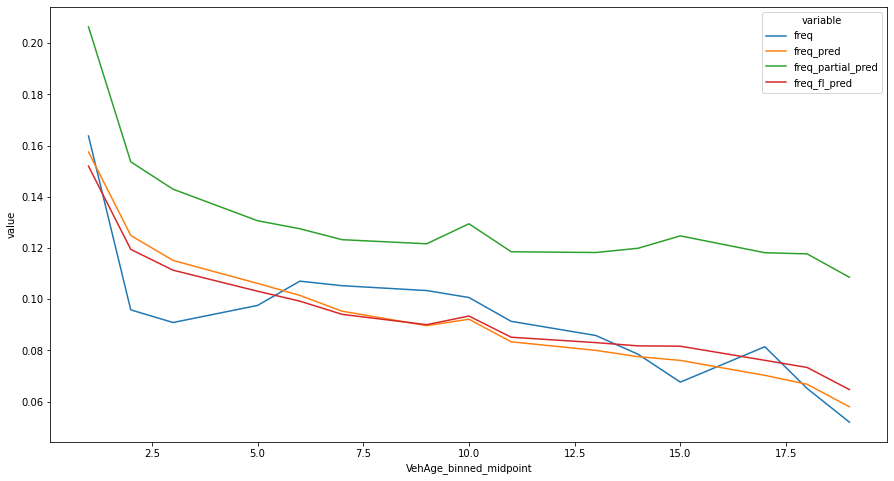

In [93]:
one_way_graph(df_fl_sum, 'freq', 'freq_pred','freq_partial_pred','freq_fl_pred')

And we can see the federated model approximates (or even improves in some places) the model trained using **ALL** the data even though it only had direct access to just $\frac{1}{10^{th}}$ of the training data!